In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import preprocessing
color = sns.color_palette()
%matplotlib inline


In [2]:
df_train = pd.read_json("train.json")
df_test = pd.read_json("test.json")

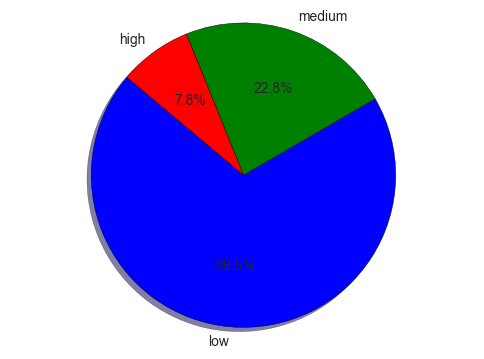

In [3]:
int_level = df_train['interest_level'].value_counts()
plt.pie(int_level,labels= ['low','medium','high'], autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [4]:
drace_df = df_train.loc[:,['interest_level', 'created', 'manager_id', 'bathrooms']]

In [5]:
drace_df.head()

,interest_level,created,manager_id,bathrooms
10,medium,2016-06-24 07:54:24,5ba989232d0489da1b5f2c45f6688adc,1.5
10000,low,2016-06-12 12:19:27,7533621a882f71e25173b27e3139d83d,1.0
100004,high,2016-04-17 03:26:41,d9039c43983f6e564b1482b273bd7b01,1.0
100007,low,2016-04-18 02:22:02,1067e078446a7897d2da493d2f741316,1.0
100013,low,2016-04-28 01:32:41,98e13ad4b495b9613cef886d79a6291f,1.0


In [6]:
drace_df.describe()

,bathrooms
count,49352.00000
mean,1.21218
std,0.50142
min,0.00000
25%,1.00000
50%,1.00000
75%,1.00000
max,10.00000


In [7]:
drace_df.manager_id.value_counts().head()

e6472c7237327dd3903b3d6f6a94515a    2533
6e5c10246156ae5bdcd9b487ca99d96a     711
8f5a9c893f6d602f4953fcc0b8e6e9b4     410
62b685cc0d876c3a1a51d63a0d6a8082     402
cb87dadbca78fad02b388dc9e8f25a5b     373
Name: manager_id, dtype: int64

In [8]:
drace_df.bathrooms.value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
10.0        1
7.0         1
Name: bathrooms, dtype: int64

In [9]:
drace_df.created = pd.to_datetime(drace_df.created)

In [10]:
drace_df['date_created'] = drace_df.created.dt.date
drace_df['weekday_created'] = drace_df.created.dt.dayofweek
drace_df['hour_created'] = drace_df.created.dt.hour

In [11]:
drace_df.head()

,interest_level,created,manager_id,bathrooms,date_created,weekday_created,hour_created
10,medium,2016-06-24 07:54:24,5ba989232d0489da1b5f2c45f6688adc,1.5,2016-06-24,4,7
10000,low,2016-06-12 12:19:27,7533621a882f71e25173b27e3139d83d,1.0,2016-06-12,6,12
100004,high,2016-04-17 03:26:41,d9039c43983f6e564b1482b273bd7b01,1.0,2016-04-17,6,3
100007,low,2016-04-18 02:22:02,1067e078446a7897d2da493d2f741316,1.0,2016-04-18,0,2
100013,low,2016-04-28 01:32:41,98e13ad4b495b9613cef886d79a6291f,1.0,2016-04-28,3,1


In [12]:
drace_df['interest_level'] = pd.Categorical(drace_df['interest_level'], categories= ['low', 'medium', 'high'], ordered=True)

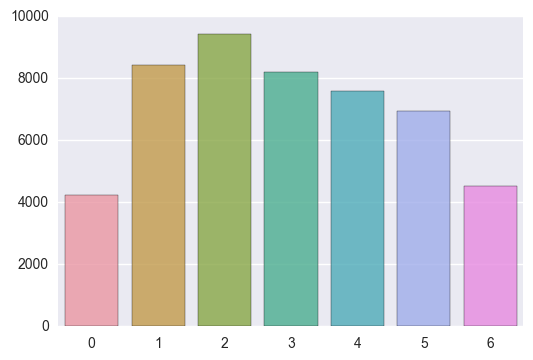

In [13]:
weekday_listings = drace_df['weekday_created'].value_counts()
sns.barplot(weekday_listings.index, weekday_listings.values, alpha=0.8)
#not sure this showed much.  A little as expected.

In [14]:
daily_listings_intrMode = drace_df.groupby(['date_created'])['interest_level'].value_counts()

In [15]:
daily_listings_intrMode = pd.DataFrame(daily_listings_intrMode)
daily_listings_intrMode = daily_listings_intrMode.unstack(level=1)

In [16]:
daily_listings_intrMode.head()

interest_level              
interest_level           high    low medium
date_created                               
2016-04-01                2.0    NaN    2.0
2016-04-02               53.0  447.0  160.0
2016-04-03               16.0  234.0   61.0
2016-04-04               32.0  234.0   79.0
2016-04-05               58.0  396.0  146.0

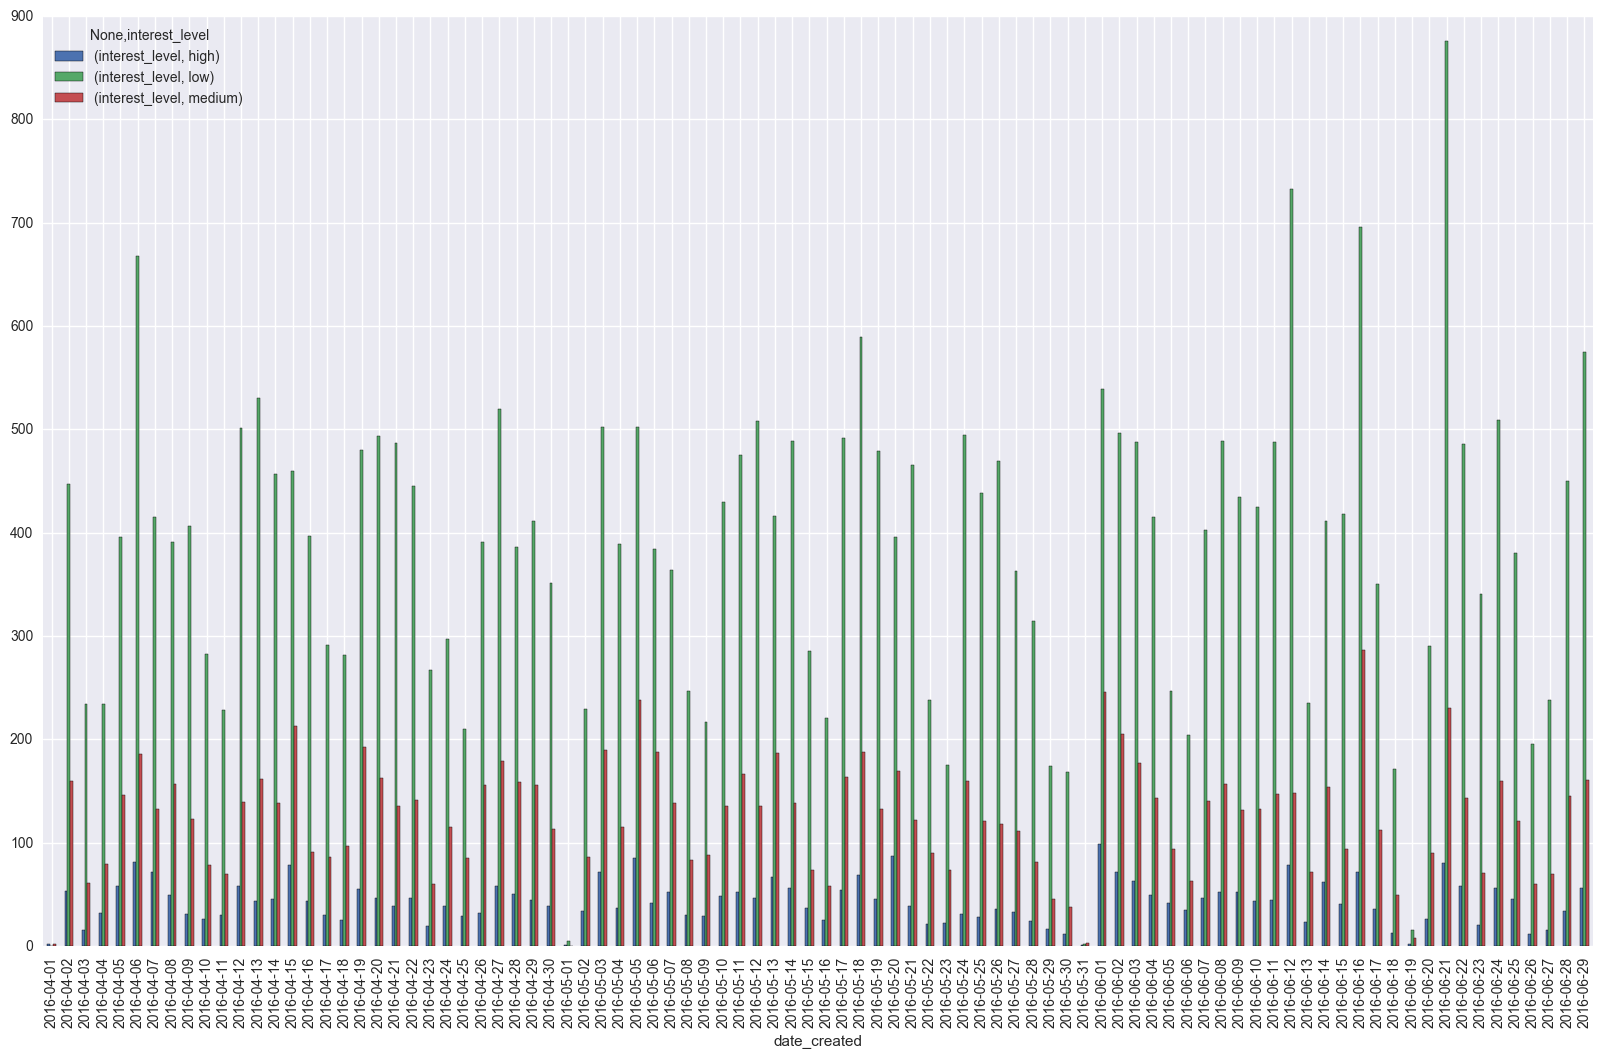

In [17]:
daily_listings_intrMode.plot(kind='bar', figsize = (20,12))

Code below was adopted from
https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/improve-perfomances-using-manager-features/notebook
The only difference is I'm changing features to predict "managerskill" as latitude, longitude, price, num_photos, num_features, num description words.

Here's my justification.  Since manager id seems fixed to actually the agency posting the ads, we would more likely measure an agency with their presentation style and the range of price their apartments are listed on.

These are preprocessing for both the original dataset (to create the feature) and the features I'm working on to join manager skill later

In [22]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(df_train['manager_id'].values))
df_train['manager_id'] = lbl.transform(list(df_train['manager_id'].values))

In [ ]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(drace_df['manager_id'].values))
drace_df['manager_id'] = lbl.transform(list(drace_df['manager_id'].values))

In [25]:
df_train["num_photos"] = df_train["photos"].apply(len)
df_train["num_features"] = df_train["features"].apply(len)
df_train["num_description_words"] = df_train["description"].apply(lambda x: len(x.split(" ")))

In [23]:
features_to_use = ["latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words"
                   ]
features_to_use.append('manager_id')

Quote from notebook: "
Let's now add 3 columns contaning the fractions of 'low','medium' and 'high' interest level obtained by each manager in the training dataset.¶
We also add the simple 'manager_skill' feature I introduced in my previous notebook.
We use mean values for those managers who don't have enough entries for being ranked (minimum = 20 here).
As pointed out by Philippe Lonjoux's, since these new features involve the target variable, we split the dataset first so to avoid "cheating" during the validation phase. The features are computed for each manager on the training part and the values obtained are then copied for the instances in the validation dataset."

In [26]:
X = df_train[features_to_use]
y = df_train["interest_level"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [27]:
# compute fractions and count for each manager
temp = pd.concat([X_train.manager_id,pd.get_dummies(y_train)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = X_train.groupby('manager_id').count().iloc[:,1]

# remember the manager_ids look different because we encoded them in the previous step 
print(temp.tail(10))

            high_frac  low_frac  medium_frac  count
manager_id                                         
3471         0.000000  0.666667     0.333333      3
3472         0.500000  0.333333     0.166667      6
3473         0.000000  1.000000     0.000000      1
3474         0.000000  1.000000     0.000000      1
3475         0.000000  0.800000     0.200000      5
3476         0.000000  1.000000     0.000000      1
3477         0.000000  1.000000     0.000000      4
3478         0.000000  1.000000     0.000000      1
3479         0.200000  0.600000     0.200000      5
3480         0.037037  0.629630     0.333333     81


In [28]:
# compute skill
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']

# get ixes for unranked managers...
unranked_managers_ixes = temp['count']<20
# ... and ranked ones
ranked_managers_ixes = ~unranked_managers_ixes

# compute mean values from ranked managers and assign them to unranked ones
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
print(mean_values)
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
print(temp.tail(10))

high_frac        0.083359
low_frac         0.660083
medium_frac      0.256558
manager_skill    0.423276
dtype: float64
            high_frac  low_frac  medium_frac  count  manager_skill
manager_id                                                        
3471         0.083359  0.660083     0.256558      3       0.423276
3472         0.083359  0.660083     0.256558      6       0.423276
3473         0.083359  0.660083     0.256558      1       0.423276
3474         0.083359  0.660083     0.256558      1       0.423276
3475         0.083359  0.660083     0.256558      5       0.423276
3476         0.083359  0.660083     0.256558      1       0.423276
3477         0.083359  0.660083     0.256558      4       0.423276
3478         0.083359  0.660083     0.256558      1       0.423276
3479         0.083359  0.660083     0.256558      5       0.423276
3480         0.037037  0.629630     0.333333     81       0.407407


In [38]:
drace_df = drace_df.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = drace_df['high_frac'].isnull()
drace_df.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
drace_df.head()

,interest_level,created,manager_id,bathrooms,date_created,weekday_created,hour_created,high_frac,low_frac,medium_frac,count,manager_skill
0,medium,2016-06-24 07:54:24,1239,1.5,2016-06-24,4,7,0.000000,0.716667,0.283333,60.0,0.283333
1,low,2016-06-12 12:19:27,1583,1.0,2016-06-12,6,12,0.000000,0.984615,0.015385,65.0,0.015385
2,high,2016-04-17 03:26:41,2965,1.0,2016-04-17,6,3,0.054348,0.608696,0.336957,92.0,0.445652
3,low,2016-04-18 02:22:02,225,1.0,2016-04-18,0,2,0.081081,0.804054,0.114865,148.0,0.277027
4,low,2016-04-28 01:32:41,2081,1.0,2016-04-28,3,1,0.083359,0.660083,0.256558,11.0,0.423276


In [31]:
# add the features computed on the training dataset to the validation dataset if we want to use the entire dataframe, 
#I didn't use it
X_val = X_val.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = X_val['high_frac'].isnull()
X_val.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
X_val.head()

,latitude,longitude,price,num_photos,num_features,num_description_words,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,40.7382,-73.9833,2649,7,17,101,822,0.083359,0.660083,0.256558,19.0,0.423276
1,40.6870,-73.9983,4500,8,4,161,1074,0.047619,0.857143,0.095238,21.0,0.190476
2,40.7488,-73.9734,3495,9,13,251,1159,0.000000,0.827586,0.172414,174.0,0.172414
3,40.6959,-73.9022,3199,7,4,190,1244,0.083359,0.660083,0.256558,1.0,0.423276
4,40.7796,-73.9528,2608,8,12,108,1499,0.005859,0.912109,0.082031,512.0,0.093750


Baseline on my current dataframe

In [34]:
feats_used = ['bathrooms', 'hour_created', 'manager_id']
x = drace_df[feats_used]
y = drace_df["interest_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train[feats_used], y_train)
y_pred = rf.predict_proba(x_test[feats_used])
log_loss(y_test, y_pred)

1.4486340851484325

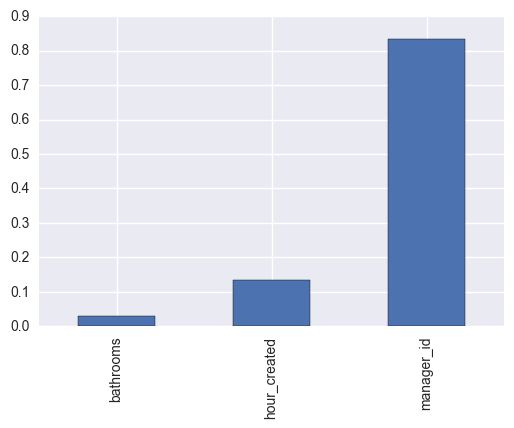

In [35]:
pd.Series(index = feats_used, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

This is now to replace manager_id with manager skill

In [39]:
drace_df.manager_skill.describe()

count    49352.000000
mean         0.408218
std          0.246271
min          0.000000
25%          0.277027
50%          0.423276
75%          0.423276
max          1.600000
Name: manager_skill, dtype: float64

In [40]:
feats_used = ['bathrooms', 'hour_created', 'manager_skill']
x = drace_df[feats_used]
y = drace_df["interest_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train[feats_used], y_train)
y_pred = rf.predict_proba(x_test[feats_used])
log_loss(y_test, y_pred)

0.98681983802497664

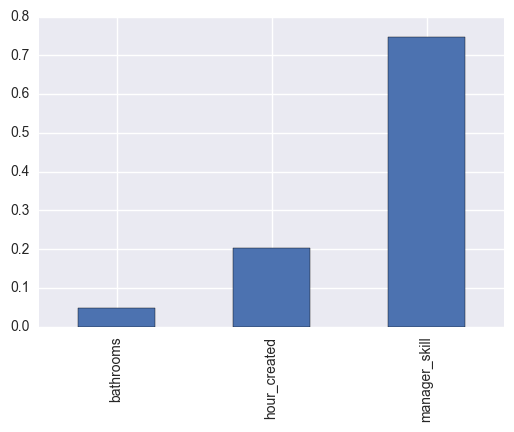

In [41]:
pd.Series(index = feats_used, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

A few questions:
Does number of listings on a certain day influence average interest levels of buildings that day
If high amount of listings cause lower average interest then we can test that people may be mostly looking at date created

I also do not quite know how to use the pipeline here:
https://www.kaggle.com/maximilianhahn/two-sigma-connect-rental-listing-inquiries/manager-skill-for-cross-validation-pipelines/notebook
maybe someone can fiddle with it
